Как я говорил ранее, в качестве основного инструмента будет использоваться нейросетевой фреймворк PyTorch. Люди, далёкие от анализа данных, думают, что нейронные сети очень сложны для понимания и требуют нескольких лет изучения. В действительности, чаще всего они представляют из себя композицию простых линейных моделей с нелинейными функциями активации. Сложности и хитрости, конечно, есть — главным образом они лежат в плоскости выбора оптимальных архитектур этих композиций и на этапе тонкой настройки параметров, однако в своей основе нейронные сети очень просты.

Соответственно, и фреймворки для построения нейронных сетей, типа PyTorch и TensorFlow, также не представляют из себя чёрных ящиков. По сути, они выполняют три главные функции:

1. Дают возможность быстро проводить матричные вычисления на GPU. Как numpy, только с возможностью распараллеливания на множесво графических процессоров. В языке Julia, кстати, такая возможность присутствует изначально.
2. Позволяют легко брать производные для заданных с помощью этих матриц уравнений. Как известно из школы, при помощи производных можно найти найти экстремумы функции, а, собственно, всё машинное обучением как раз об этом — о нахождении минимума функции потерь.
3. Предоставляют доступ к набору готовых архитектур, основным компонентам и утилитарных функций для самостоятельной реализации новых.

Итак, давайте реализуем одну из самых простых и изученных моделей — линейную регрессию. Именно с неё для многих начинается погружение в мир машинного обучения. Напомню, что простая линейная регрессия моделирует зависимость между зависимой и независимой переменной при помощи уравнения $y_i = b + k\cdot x_{i}$, где свободный коэффициент $b$ задаёт положение прямой по оси $Oy$, а угловой коэффициент $k$, тангенс угла наклона. В матричной форме эта формула будет выглядеть как $y=X^T\cdot w$.

В качестве простого примера смоделируем линейную зависимость оценок вина от его цены, построив регрессионную модель с одним предиктором, используя набор данных из предыдущей статьи.

In [1]:
import pandas as pd
import torch
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

wine_url = "https://nagornyy.me/datasets/wine_reviews.csv.zip"
df_wine = pd.read_csv(wine_url)
# удаляем вина без рейтинга или без цены
df_wine.dropna(subset=["points", "price"], inplace=True)
df_wine.shape

(18198, 10)

In [2]:
df_wine.head(2)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,"With a delicate, silky mouthfeel and bright ac...",NaN,86,23.0,California,Central Coast,Central Coast,Pinot Noir,MacMurray Ranch
1,Italy,D'Alceo is a drop dead gorgeous wine that ooze...,D'Alceo,96,275.0,Tuscany,Toscana,NaN,Red Blend,Castello dei Rampolla


Цена, как это обычно бывает, распределена не нормально, и логарифмирование частично решает эту проблему — после неё начинает угадываться линейный тренд.

In [3]:
y = df_wine.points.values
X = np.log(df_wine.price.values)

В качестве бейзлайна давайте воспользуемся хорошо известной библиотекой [statsmodels](https://www.statsmodels.org), где реализовано множество видов регрессионных моделей и много чего ещё. Пока не будем использовать никаких нейронных сетей, а решим всё по аналитически, при помощи метода наименьших квадратов, оценки которого являются [наилучшими при соблюдении ряда условий](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%93%D0%B0%D1%83%D1%81%D1%81%D0%B0_%E2%80%94_%D0%9C%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D0%B0), но сложность вычисления которого растёт значительно [быстрее](https://math.stackexchange.com/a/84503), чем увеличивается количество параметров. 

In [4]:
model = sm.OLS(y, sm.add_constant(X)).fit()

Посмотрим, что получилось, наложив график предскзанных значений на график предсказанных и посчитав коэффициент детерминации $R^2$.

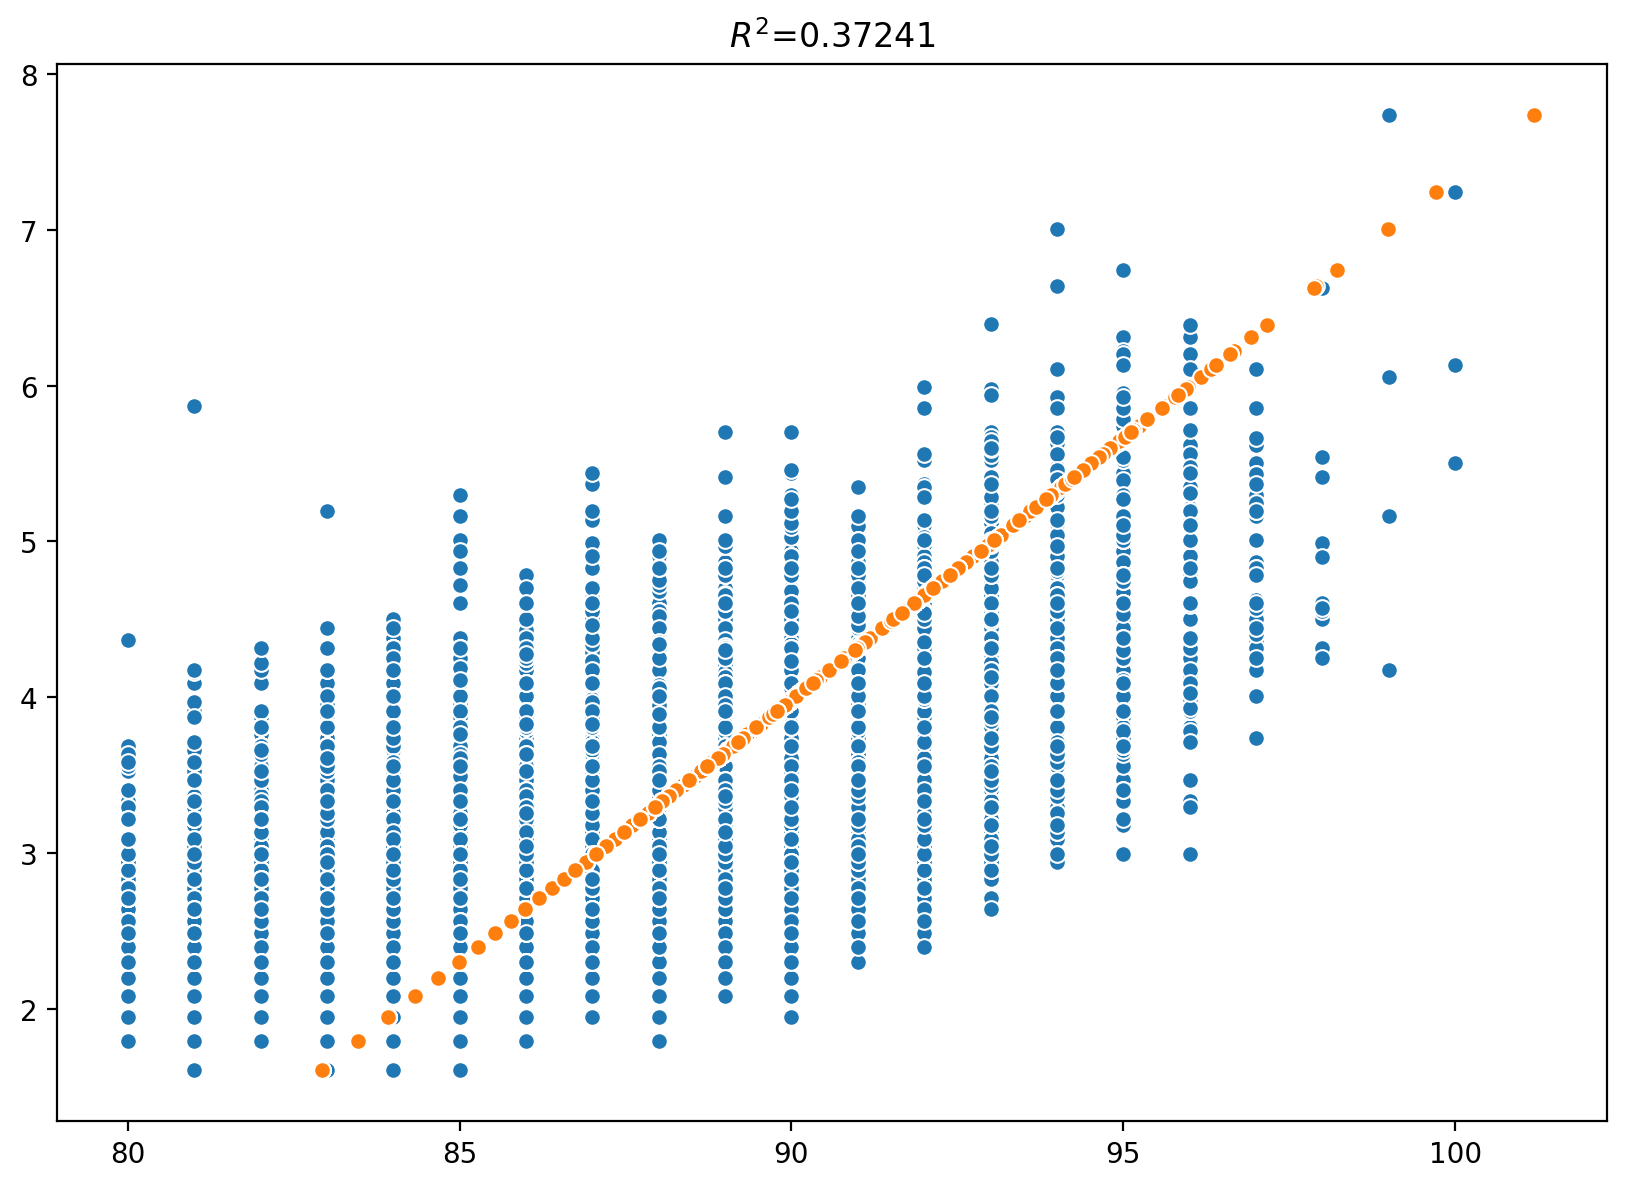

In [5]:
predicted = model.predict(sm.add_constant(X))
r2 = r2_score(y, predicted)
plt.figure(figsize=(10, 7), dpi=200)
plt.title(f"$R^2$={r2:.5f}")
sns.scatterplot(y, X)
sns.scatterplot(predicted, X);

Выглядит неплохо — получилось, что баллы вина на 37% определяются его ценой. Причём, напомню, математически доказано, что эти оценки — самые лучшие из всех возможных.

Попробуем сделать то же самое, но в PyTorch с использованием только лишь функций перемножения матриц и автоматического дифференцирования.

Для начала переформатируем данные из вектора в матрицу с одним столбцом и сконвертируем их в то, что в мире нейросетевых фреймфорков называется тезнорами, а по сути это те же многомерные матрицы и вектора, которые теперь могут вычисляться на видеокарте.

In [6]:
y_tensor = torch.from_numpy(y.reshape(-1, 1)).float()
X_tensor = torch.from_numpy(X.reshape(-1, 1)).float()

Затем определим функцию простой линейной регрессии. В коде она выглядит точно так же, как и на формуле. Оператор `@`, если кто не знает, в Python обозначает [матричное умножение](http://matrixmultiplication.xyz/).

In [7]:
def lin_reg_model(X, w, b):
    return X @ w.t() + b

Далее запишем функцию потерь — пусть это будет функция [среднекватратичной ошибки](https://en.wikipedia.org/wiki/Mean_squared_error) $MSE =\frac{1}{n}\sum_{i=1}^{n}(y_{i}-\hat{y_i})^{2}$, где $y$ — это истинные значения зависимой переменной, а $\hat{y_{i}}$ — предсказанные. Получается, что штраф увеличивается пропорционально квадрату ошибки.

In [8]:
def mse(true, predicted):
    return ((true - predicted) ** 2).sum() / true.numel()

А в общем-то на этом почти всё. Далее надо всего лишь определить переменные, в которых будут хранится параметры модели. В нашем случае их всего два — угловой коэффициент `weight` и свободный коэффициент `bias`. Пока можно заполнить эти матрицы случайными числами, мы всё равно подберём их позже. Главное не забыть установить `requires_grad_` на `True`, после чего PyTorch начнёт записывать историю всех вычислений, в которых принимал участие этот параметр, чтобы потом взять производную по нему от итоговой сложной функции.

In [34]:
# по мотивами Kaiming initialization
weight = torch.randn(y_tensor.shape[1], X_tensor.shape[1]) / math.sqrt(2 / y_tensor.shape[1])
bias = torch.zeros(y_tensor.shape[1])
# начинаем записывать историю вычислений
weight.requires_grad_(True)
bias.requires_grad_(True);

<div class="note">Kaiming initialization — это способ задать начальные веса параметров, чтобы найти минимум функции потерь быстрее (https://www.zotero.org/ihun/items/itemKey/6ID8VZE6).</div>

Далее вычисляем значение функции при данных параметрах (forward pass) и берём частную производную этой же функции, обёрнутую в функцию потерь по каждому из параметров (backward pass) по [цепному правилу](http://ru.wikipedia.org/wiki/Дифференцирование_сложной_функции) (chain rule), получая таким образом градиент — вектор, координаты которого составляют частные производные и который указывает на направление наискорейшего возрастания функции.

Знание градиента необходимо, чтобы выполнить градиентный спуск. Производная функции по параметру, как известно, показывает как сильно изменяется эта функция при изменении аргумента. Поскольку мы берём производную от функции потерь, она будет показывать, как изменение параметра влияет на ошибку предсказания, а так как мы хотим уменьшить эту ошибку, следует стремиться к тому, чтобы изменение параметра не приводило к увеличению функции. Самый простой способ сделать это — вычесть из каждого параметра производную функции по нему. Таким образом мы спускаемся по направлению антиградиента, то есть в сторону скорейшего уменьшения функции. Такой алгоритм поиска минимума фукнции называется градиентным спуском, а в целом всё это называется методом обратного распространения ошибки. Именно он лежит в основе практически всего глубокого обучения, поэтому следует представлять (https://www.zotero.org/ihun/items/itemKey/B6ZGGLPS), как он работает.

In [35]:
learning_rate = 0.01
epochs = 10000

for epoch in range(epochs):
    # forward pass — вычисляем функцию потерь
    predictions = lin_reg_model(X_tensor, weight, bias)
    loss = mse(predictions, y_tensor)
    # backward paass — вычисляем градиент
    loss.backward()
    # вычитаем производные из параметров
    # записывать историю вычислений уже не нужно (no_grad)
    with torch.no_grad():
        weight -= weight.grad * learning_rate
        bias -= bias.grad * learning_rate
        # обнуляем производные
        weight.grad.zero_()
        bias.grad.zero_()
    # выводим значение фукнции потерь каждые 2000 повторов
    if (epoch + 1) % (epochs / 10) == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 999, loss 52.46626281738281
epoch 1999, loss 17.059465408325195
epoch 2999, loss 8.96900749206543
epoch 3999, loss 7.120398998260498
epoch 4999, loss 6.697981357574463
epoch 5999, loss 6.601466655731201
epoch 6999, loss 6.579410076141357
epoch 7999, loss 6.574369430541992
epoch 8999, loss 6.573214054107666
epoch 9999, loss 6.572952747344971


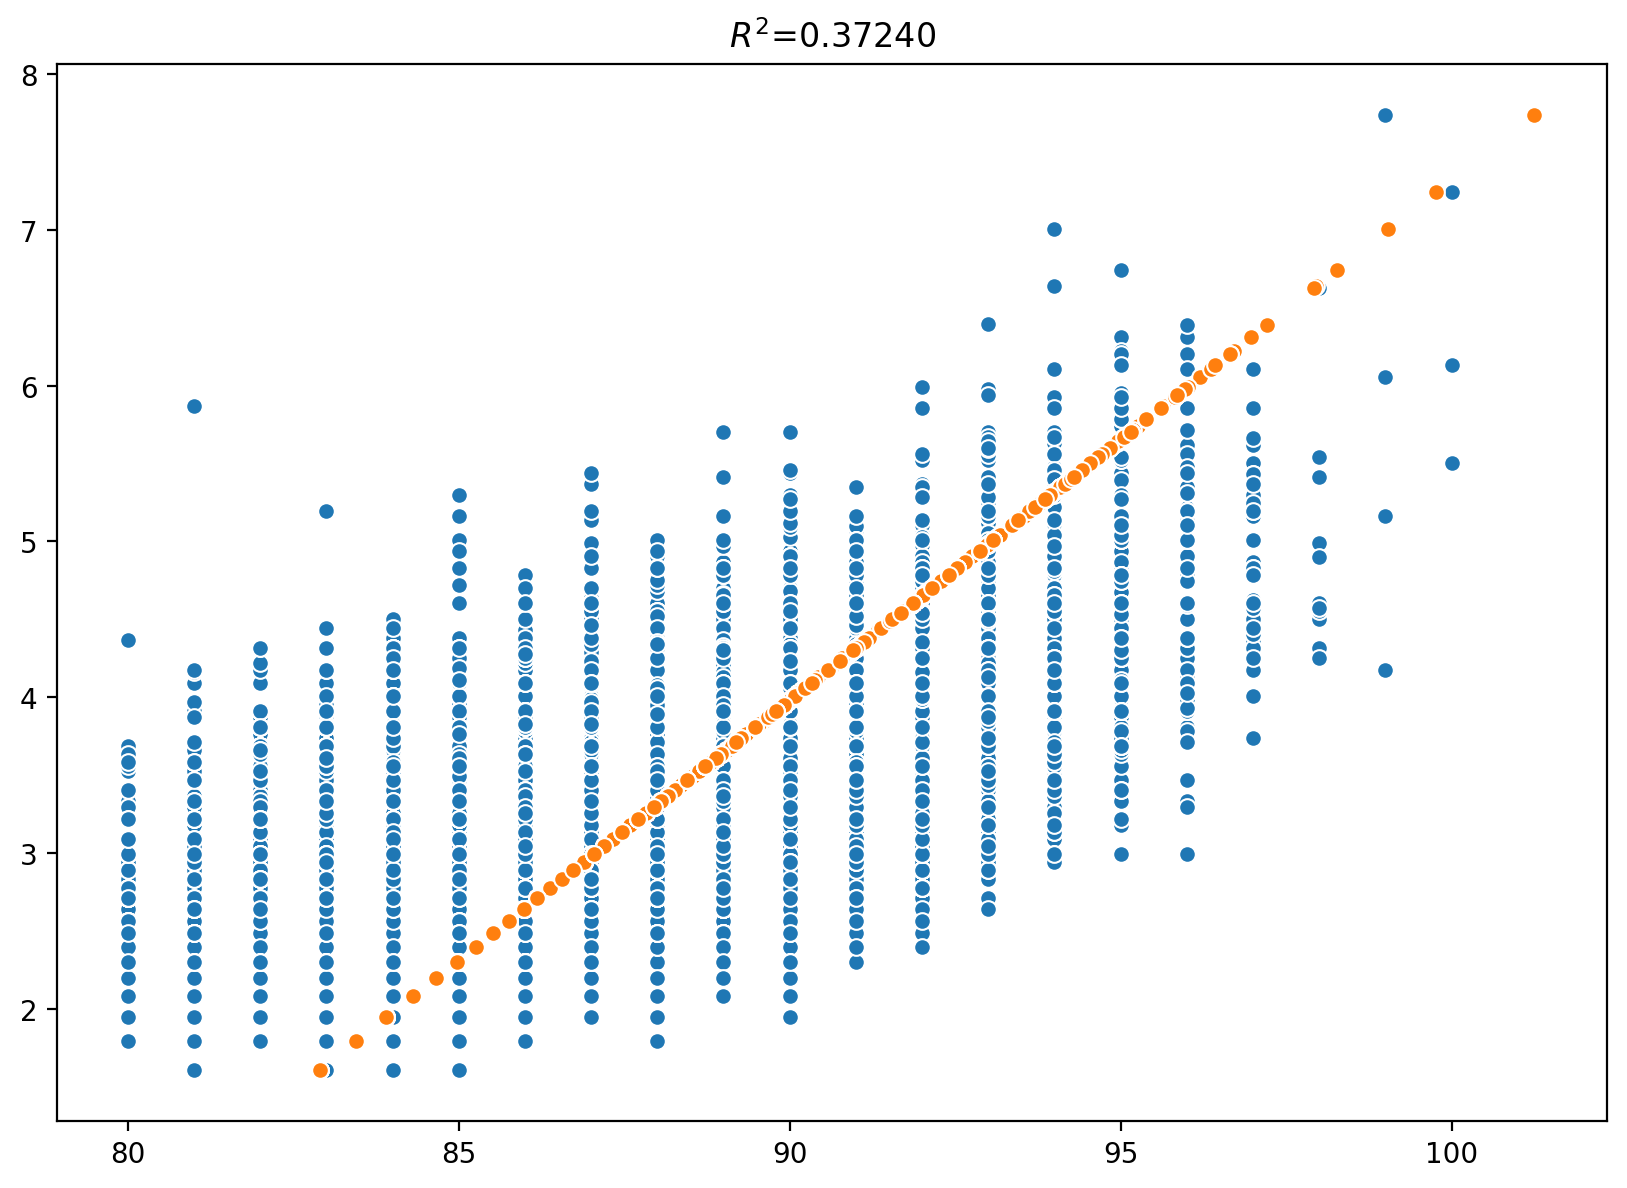

In [36]:
predicted = lin_reg_model(X_tensor, weight, bias)
r2 = r2_score(y_tensor.squeeze().numpy(), predicted.squeeze().detach().numpy())

plt.figure(figsize=(10, 7), dpi=200)
plt.title(f"$R^2$={r2:.5f}")
sns.scatterplot(y_tensor.squeeze(1).numpy(), X_tensor.squeeze(1).numpy())
sns.scatterplot(predicted.squeeze(1).detach().numpy(), X_tensor.squeeze(1).numpy());

Готово! Параметры подобраны, и мы получили всё тот же $R^2$ равный 0.37, т.е. почти столько же, сколько при помощи метода наименьших квадратов. Конечно, модель, чьи веса подобраны градиентным спуском, немного менее точна, поскольку это численный, приближённый метод, однако он подходит для вычисления функций с миллионами параметров (у нас, напомню, их две штуки).

Чтобы построить множественную регрессию, т.е. модель с более чем одной независимой переменной, в этом коде не нужно ничего менять — достаточно лишь передать функции `lin_reg_model` матрицы $X$ и $w$ не с одним, а с несколькими столбцами. Можете сделать это самостоятельно.

Стоит, однако, заметить, что в этом решении не используется множество алгоритмических хитростей, связанных с адаптивными алгоритмами градиентного спуска, помогающими найти минимум функции быстрее и надёжнее, разбиением данных на батчи для уменьшения поребления памяти и уменьшения переобучения, а также игнорируются встроенные в PyTorch модули, позволяющие лучше структурировать код, без чего сложно будет построить сложные композиции слоёв. Более правильно было бы реализовать нашу модель иначе.

In [45]:
from torch import nn, optim

class LinearRegression(nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize)

    def forward(self, X):
        predictions = self.linear(X)
        return predictions

model = LinearRegression(1, 1)
criterion = nn.MSELoss() 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor)
    # get gradients
    loss.backward()
    # update parameters
    optimizer.step()
    
    if (epoch + 1) % (epochs / 10) == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 999, loss 53.20067596435547
epoch 1999, loss 17.227285385131836
epoch 2999, loss 9.007390022277832
epoch 3999, loss 7.129148960113525
epoch 4999, loss 6.699985027313232
epoch 5999, loss 6.601927757263184
epoch 6999, loss 6.579513072967529
epoch 7999, loss 6.574390411376953
epoch 8999, loss 6.573218822479248
epoch 9999, loss 6.572952747344971


Сейчас особой разницы нет, но в будущем лучше писать именно в таком стиле, т.к. он позволяет легко менять методы оптимизации, предоставляет возможность легко строить композиции слоёв и много чего ещё. Попробуем этот стиль на новой моделе — на этот раз классификаторе.